# Group Project - AI for Security

**Members:**
- Andrea Ferrazzano - andrea1.ferrazzano@mail.polimi.it - 10703279
- Marco Gorini - marco2.gorini@mail.polimi.it - 10710545
- Leonardo Saveri - leonardo.saveri@mail.polimi.it - 10745545
- Claudia Pierpaoli - claudia.pierpaoli@mail.polimi.it - 11016822

# Objective:
In this section of the project, we will train unsupervised classifiers.

We will use the following metrics to evaluate them:

**Homogeneity score:** A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

**Completeness score:** A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

**V-measure score:** the harmonic mean between homogeneity and completeness.

**Distortion score:** the sum of square distances from each point to its assigned center.

**calinski_harabasz_score:** The score is defined as ratio of the sum of between-cluster dispersion and of within-cluster dispersion.

# Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    v_measure_score,
    silhouette_score,
    calinski_harabasz_score,
)

import time
from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score
)
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Because we are working with unlabeled data, it does't make sense to use the modified data we processed. We will use the full dataset we were able to obtain from the Kaggle Repository. 
This is because when we were processing the dataset, we looked at the distributions by label. 

In [2]:
df = pd.read_csv("data/full_balanced_data.csv")

df.shape

(153064, 48)

In [3]:
df.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label',
       'category_label'],
      dtype='object')

We will just remove columns that have all same value

In [18]:
def is_unique(s):
    a = s.to_numpy()
    return (a[0] == a).all()

col = []
for i in df.columns:
    out = is_unique(df[i])
    if out == False:
        col.append(i)

df = df[col]

In [19]:
df.shape

(153064, 44)

In [20]:
X = df.drop(columns=["label", "category_label"])

y = df["category_label"]

Now we are scaling values in the train and the test set (everything in this case, because there are only numerical features) to have better performances and predictions.

In [21]:
standard_scaler = StandardScaler().fit(X)

X = standard_scaler.transform(X)

Let's save the standars scaler also for the future

In [22]:
#dump(standard_scaler, "scalers/standard_scaler.bin", compress=True)

In [23]:
X

array([[-0.09225225, -0.38725648, -0.52567095, ..., -0.22467681,
        -1.2470541 ,  0.00223954],
       [-0.09433133, -0.38733216, -0.96823971, ..., -0.22467681,
        -1.2470541 ,  0.00223954],
       [-0.09433133, -0.38728425, -0.52567095, ..., -0.22466911,
        -1.17866775,  0.00223954],
       ...,
       [-0.09406873,  0.04294229, -0.52567095, ...,  0.4295219 ,
         0.8045363 , -1.2954638 ],
       [-0.09426278, -0.38685539, -0.52567095, ..., -0.22456615,
        -0.10728166, -1.2954638 ],
       [-0.01101208, -0.37959922,  0.15588494, ..., -0.22321886,
         1.03249079,  1.29994288]])

Here we assigned numerical values to each label

In [24]:
label2id = {'BenignTraffic': 0, 'Mirai': 1, 'DDoS': 2, 'Spoofing': 3, 'Web': 4, 'Recon': 5, 'BruteForce': 6, 'DoS': 7}
id2label = {0: 'BenignTraffic', 1: 'Mirai', 2: 'DDoS', 3: 'Spoofing', 4: 'Web', 5: 'Recon', 6: 'BruteForce', 7: 'DoS'}
y = [label2id[label] for label in y]

# Unsupervised Learning

## Helper function to plot KMeans after PCA

In [25]:
def plot_data_C(ax, X, col):
    ax.scatter(X[:, 0], X[:, 1], c=col, marker='.', s=2)

def plot_centroids_C(ax, centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    ax.scatter(centroids[:, 0], centroids[:, 1],
               marker='o', s=35, linewidths=8,
               color=circle_color, zorder=10, alpha=0.9)
    ax.scatter(centroids[:, 0], centroids[:, 1],
               marker='x', s=2, linewidths=12,
               color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, col, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True, ax=None):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    ax.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
               linewidths=1, colors='k')
    plot_data_C(ax, X, col)
    if show_centroids:
        plot_centroids_C(ax, clusterer.cluster_centers_)

    if show_xlabels:
        ax.set_xlabel("$x_1$", fontsize=14)
    else:
        ax.tick_params(labelbottom=False)
    if show_ylabels:
        ax.set_ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        ax.tick_params(labelleft=False)
    return ax


In [26]:
pca = PCA(n_components = 2)
X_PCA_2 = pca.fit_transform(X)
print(X_PCA_2.shape)

(153064, 2)


In [27]:
col = []
for c in y:
  if c == 0:
    col.append("b")
  elif c == 1:
    col.append("g")
  elif c == 2:
    col.append("r")
  elif col == 3:
    col.append("c")
  elif col == 4:
    col.append("m")
  elif col == 5:
    col.append("y")
  elif col == 6:
    col.append("#000000")
  else:
    col.append("#FFC0CB")
print(len(col))

153064


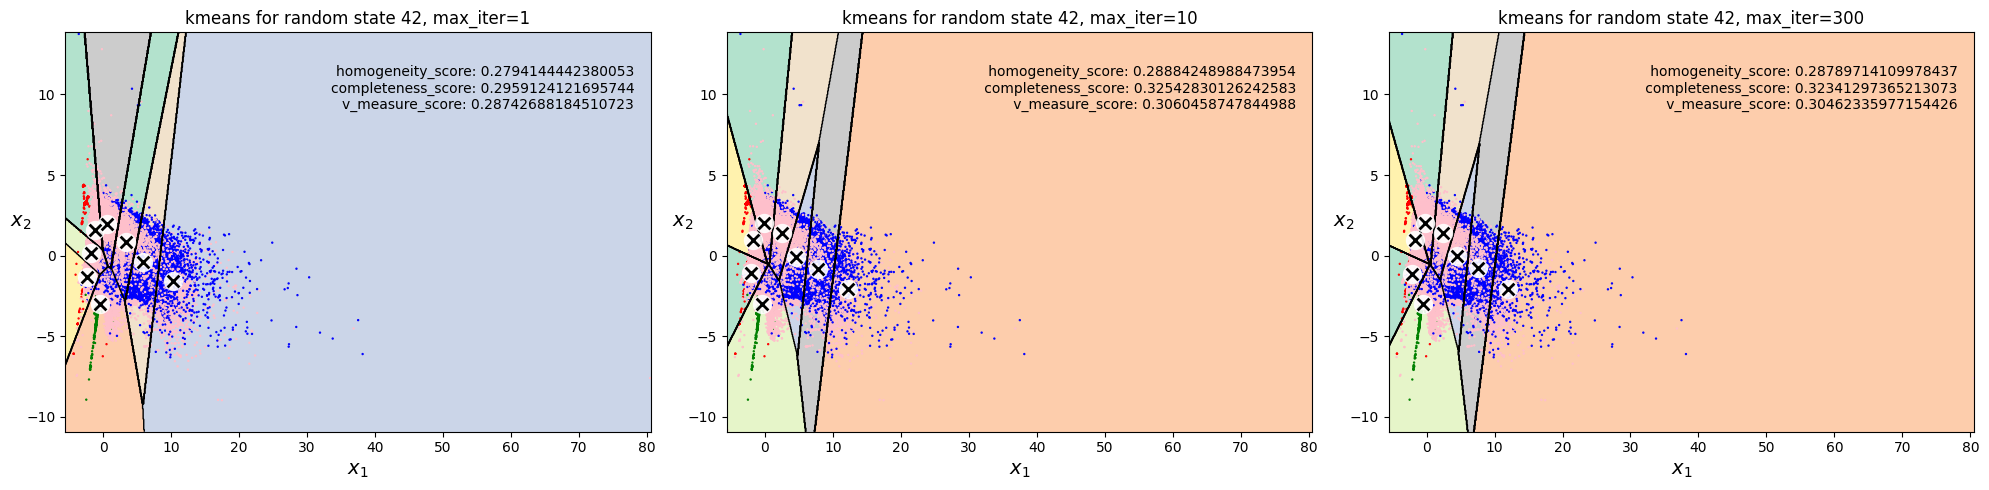

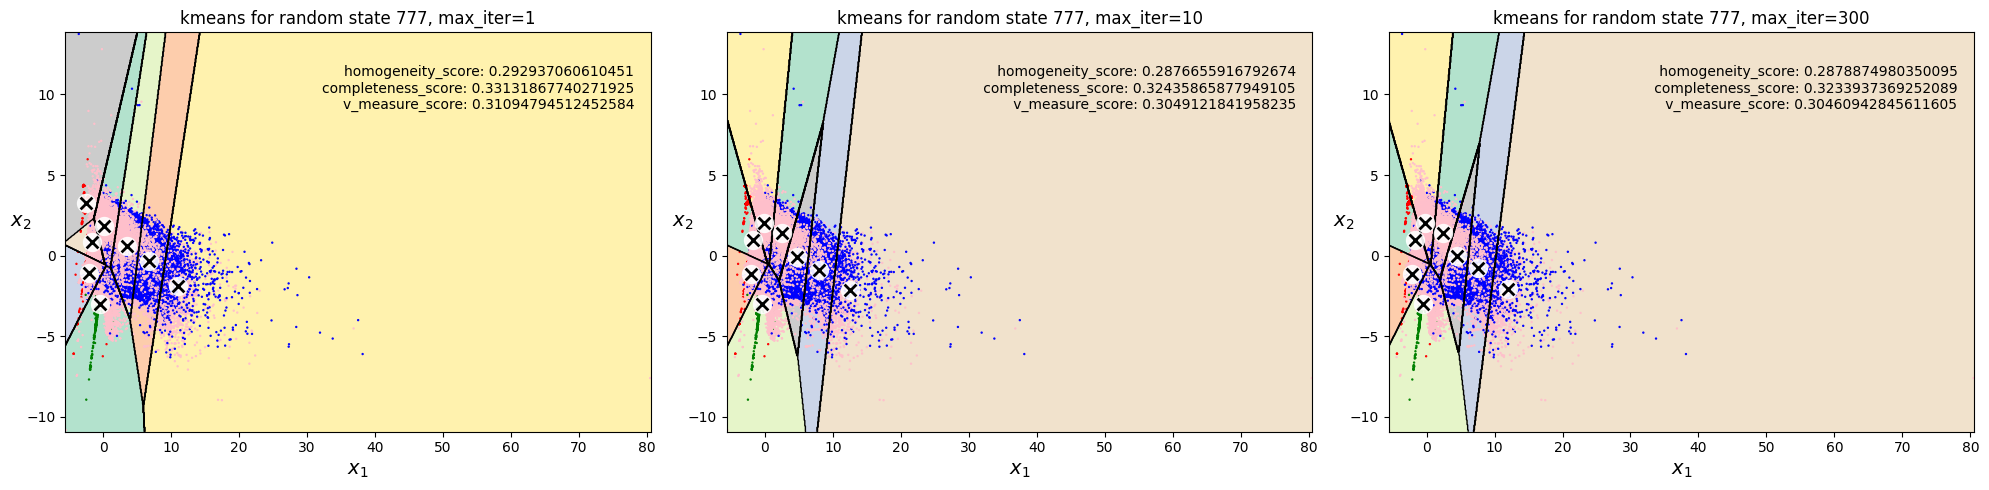

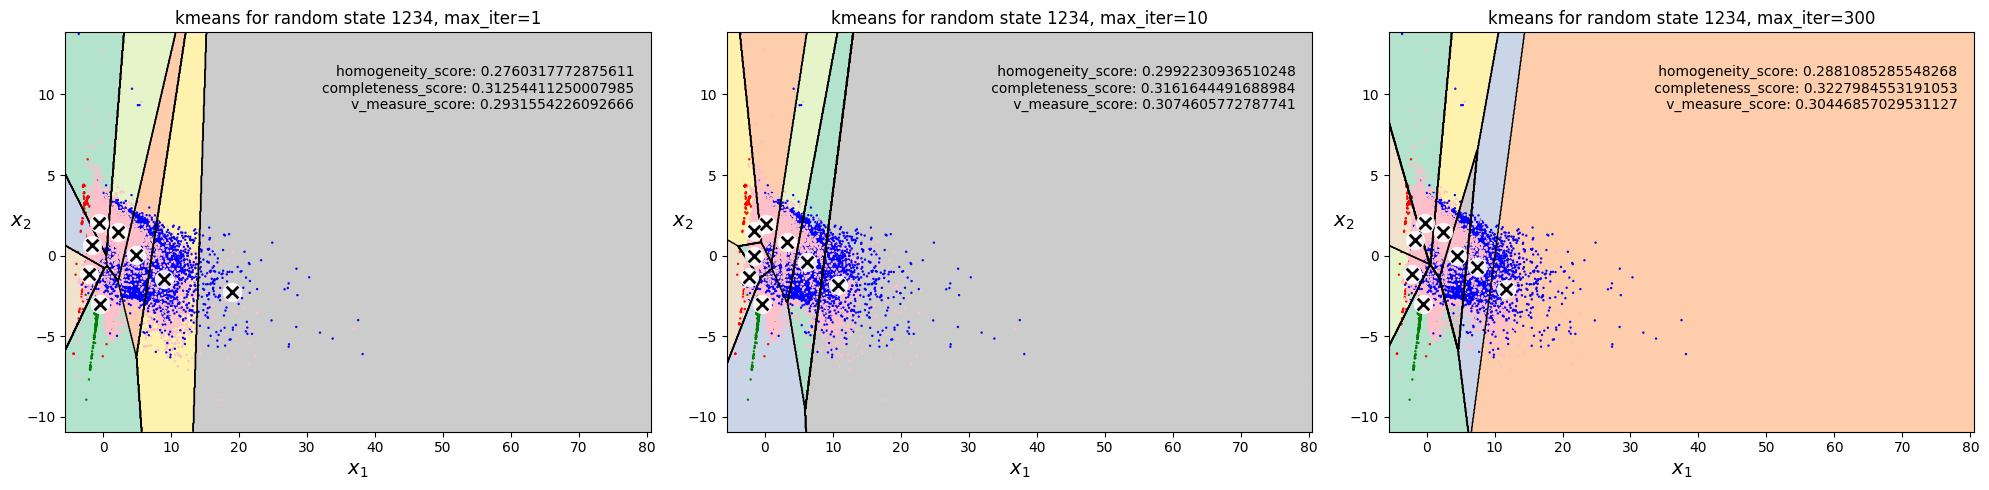

In [29]:
from sklearn import metrics
from scipy import stats

k = 8
for i in [42, 777, 1234]:
  kmeans1 = KMeans(n_clusters=k, random_state=i, n_init=10, max_iter=1)
  kmeans10 = KMeans(n_clusters=k, random_state=i, n_init=10, max_iter=10)
  kmeans300 = KMeans(n_clusters=k, random_state=i, n_init=10, max_iter=300)

  kmeans1.fit(X_PCA_2)
  kmeans10.fit(X_PCA_2)
  kmeans300.fit(X_PCA_2)

  y_pred_1 = kmeans1.predict(X_PCA_2)
  y_pred_10 = kmeans10.predict(X_PCA_2)
  y_pred_300 = kmeans300.predict(X_PCA_2)

  
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
  axes[0].clear()
  plot_decision_boundaries(kmeans1, X_PCA_2, col, ax=axes[0])
  axes[0].set_title(f"kmeans for random state {i}, max_iter=1")
  axes[0].annotate(f"""
                homogeneity_score: {homogeneity_score(y, y_pred_1)}
                completeness_score: {completeness_score(y, y_pred_1)}
                v_measure_score: {v_measure_score(y, y_pred_1)}""",
                xy=(1, 1), xytext=(-12, -12), va='top', ha='right',
                xycoords='axes fraction', textcoords='offset points')


  axes[1].clear()
  plot_decision_boundaries(kmeans10, X_PCA_2, col, ax=axes[1])
  axes[1].set_title(f"kmeans for random state {i}, max_iter=10")
  axes[1].annotate(f"""
              homogeneity_score: {homogeneity_score(y, y_pred_10)}
              completeness_score: {completeness_score(y, y_pred_10)}
              v_measure_score: {v_measure_score(y, y_pred_10)}""",
              xy=(1, 1), xytext=(-12, -12), va='top', ha='right',
              xycoords='axes fraction', textcoords='offset points')

  axes[2].clear()
  plot_decision_boundaries(kmeans300, X_PCA_2, col, ax=axes[2])
  axes[2].set_title(f"kmeans for random state {i}, max_iter=300")
  axes[2].annotate(f"""
              homogeneity_score: {homogeneity_score(y, y_pred_300)}
              completeness_score: {completeness_score(y, y_pred_300)}
              v_measure_score: {v_measure_score(y, y_pred_300)}""",
              xy=(1, 1), xytext=(-12, -12), va='top', ha='right',
              xycoords='axes fraction', textcoords='offset points')

  plt.tight_layout()
  plt.show()

In the graphs above, the colored points our labels, the x's are the centroids and the lines are the decision boundaries for each label.

In [30]:
pca = PCA(n_components=0.95)
low = pca.fit_transform(X)
low.shape

(153064, 24)

In [31]:
k = 8
homogeneity_scores = []
completeness_scores = []
v_measure_scores = []
for i in [42, 777, 1234]:
  kmeans300 = KMeans(n_clusters=k, random_state=i, n_init=10, max_iter=300)

  kmeans300.fit(low)

  y_pred_300 = kmeans300.predict(low)

  homogeneity_scores.append(homogeneity_score(y, y_pred_300))
  completeness_scores.append(completeness_score(y, y_pred_300))
  v_measure_scores.append(v_measure_score(y, y_pred_300))

print(f"homogeneity_scores: {homogeneity_scores}\t mean: {np.mean(homogeneity_scores)}")
print(f"completeness_scores: {completeness_scores}\t mean: {np.mean(completeness_scores)}")
print(f"v_measure_scores: {v_measure_scores}\t\t mean: {np.mean(v_measure_scores)}")

homogeneity_scores: [0.30056590362428914, 0.30692794252012123, 0.30265663118413055]	 mean: 0.30338349244284696
completeness_scores: [0.36823037734485575, 0.36674136401404195, 0.3696466973289305]	 mean: 0.36820614622927605
v_measure_scores: [0.3309752140014537, 0.33417931083414854, 0.3328141313515469]		 mean: 0.3326562187290497


we can see that the 1234 random state, using a PCA with 24 features (95% of variance) works better than the others

In [32]:
pca.explained_variance_ratio_

array([0.19141727, 0.08275136, 0.07633586, 0.0611547 , 0.05323904,
       0.05001338, 0.04734656, 0.04511688, 0.03811467, 0.03409679,
       0.02761397, 0.02642667, 0.02431798, 0.02380349, 0.02372975,
       0.02314458, 0.02225953, 0.02114544, 0.01793775, 0.01521524,
       0.01429797, 0.01227503, 0.01047544, 0.00964015])

In [33]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum = np.append(0, cumsum)
d = np.argmax(cumsum >= 0.95)
d

24

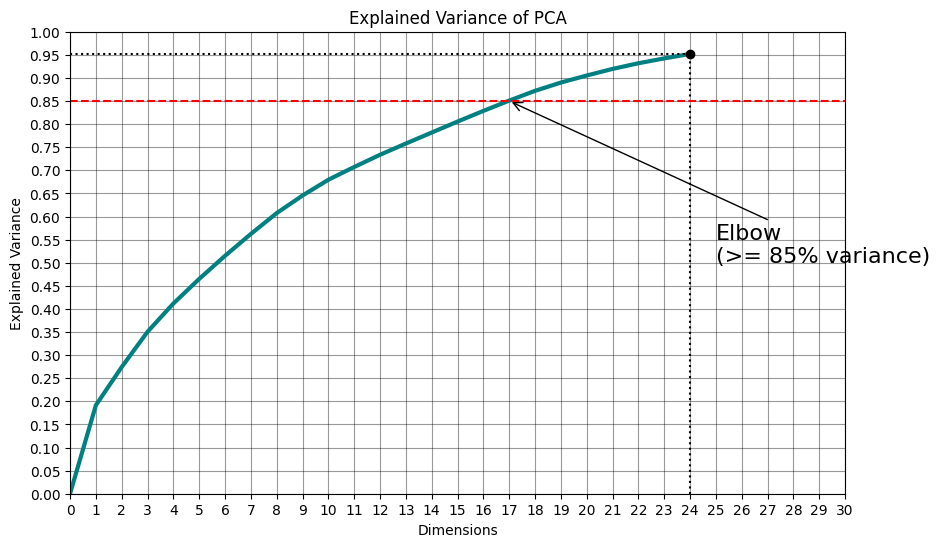

In [34]:
plt.figure(figsize=(10,6))
plt.grid(True, alpha=0.4, c="black")
plt.plot(cumsum, linewidth=3, c="teal")
plt.axis([0, 30, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.yticks(np.linspace(0,1,21))
plt.xticks(np.linspace(0,30,31))
plt.title("Explained Variance of PCA")
plt.plot([d, d], [0, cumsum[-1]], "k:")
plt.plot([0, d], [cumsum[-1], cumsum[-1]], "k:")
plt.plot(d, cumsum[-1], "ko")
plt.axhline(y=0.85, c="r", linestyle="--")
plt.annotate("Elbow\n(>= 85% variance)", xy=(np.argmax(cumsum >= 0.85), 0.85),
             xytext=(np.argmax(cumsum >= 0.85)+8, 0.5),
             arrowprops=dict(arrowstyle="->", color = "black"), fontsize=16)
# save_fig("explained_variance_plot")
plt.show()

According to this graph, the "Elbow" (which is when the explained variance for PCA reaches 85%) is at 17 dimensions. Additionally, the 95% explained variance -which we have selected- is reached with 24 dimensions.

In [36]:
k = 8
homogeneity_scores = []
completeness_scores = []
v_measure_scores = []
for i in [42, 777, 1234]:
  kmeans300 = KMeans(n_clusters=k, random_state=i, n_init=10, max_iter=300)

  kmeans300.fit(X)

  y_pred_300 = kmeans300.predict(X)

  homogeneity_scores.append(homogeneity_score(y, y_pred_300))
  completeness_scores.append(completeness_score(y, y_pred_300))
  v_measure_scores.append(v_measure_score(y, y_pred_300))

print(f"homogeneity_scores: {homogeneity_scores}\t mean: {np.mean(homogeneity_scores)}")
print(f"completeness_scores: {completeness_scores}\t mean: {np.mean(completeness_scores)}")
print(f"v_measure_scores: {v_measure_scores}\t\t mean: {np.mean(v_measure_scores)}")

homogeneity_scores: [0.2669532676877738, 0.2245389988080147, 0.3562568737666425]	 mean: 0.28258304675414364
completeness_scores: [0.3323773756505023, 0.3155165607007077, 0.4131955445354732]	 mean: 0.3536964936288944
v_measure_scores: [0.296094409727378, 0.2623647563651861, 0.3826195082350512]		 mean: 0.3136928914425384


PCA is okay. We would need 24 dimensions to keep 95% of the variance. The PCA in two dimensions is not really helpful since it maintains less than 30% of the variance.

We chose k=8 because the number of labels are 8. 

### Let's test with tsne and UMAP (better for large datasets)

Both take extremely long, we weren't able to run them. Ideally, we would have done the same analysis that was done for pca.

In [ ]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

In [ ]:
with open('data/reduced/test.npy', 'wb') as f:
    np.save(f, X_tsne)

In [ ]:
!pip3 install umap-learn

In [ ]:
import umap.umap_ as umap

embedding = umap.UMAP(n_jobs=-1).fit_transform(X)

In [ ]:
with open('data/reduced/umap.npy', 'wb') as f:
    np.save(f, embedding)

## KMeans++

Uses data distribution to first set the centroids, instead of randomly plotting them. 

In [38]:
from sklearn.cluster import kmeans_plusplus

homogeneity_scores = []
completeness_scores = []
v_measure_scores = []

k = 8
accuracy_scores = []
for i in [42, 777, 1234]:
  centroids, indices = kmeans_plusplus(X, n_clusters = k, random_state=i)
  kmeans = KMeans(n_clusters=k, random_state=i, n_init='auto')
  kmeans.fit(centroids)
  y_pred = kmeans.predict(X)
  homogeneity_scores.append(homogeneity_score(y, y_pred))
  completeness_scores.append(completeness_score(y, y_pred))
  v_measure_scores.append(v_measure_score(y, y_pred))
  

print(f"homogeneity_scores: {homogeneity_scores}\t mean: {np.mean(homogeneity_scores)}")
print(f"completeness_scores: {completeness_scores}\t mean: {np.mean(completeness_scores)}")
print(f"v_measure_scores: {v_measure_scores}\t mean: {np.mean(v_measure_scores)}")
  



homogeneity_scores: [0.23574583121575773, 0.23027245094576904, 0.2272843275507588]	 mean: 0.23110086990409517
completeness_scores: [0.29582280918189474, 0.40363199123803906, 0.3068577598686748]	 mean: 0.3354375200962029
v_measure_scores: [0.2623894215843747, 0.29324712596209834, 0.26114384635905963]	 mean: 0.27226013130184423


KMeans++ does not get better. We can see this through the low scores above

## Let's try with various number of clusters
By looking at the distortion score according to the number of clusters, we can determine the best number of clusters by finding the elbow within the graph.

In [ ]:
!pip3 install yellowbrick

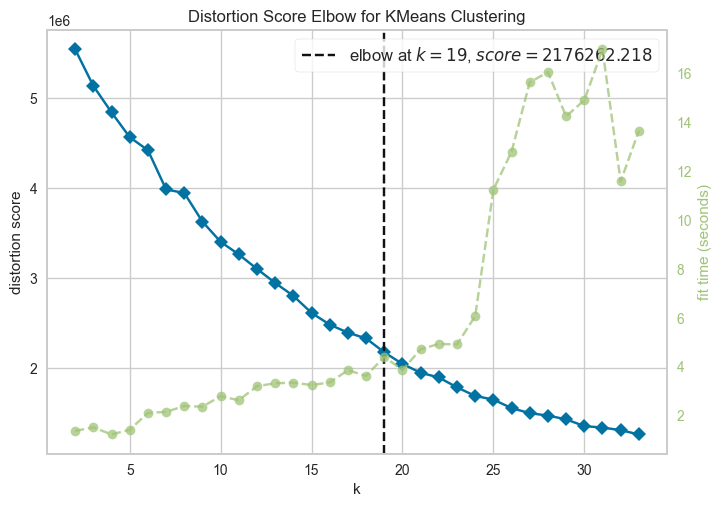

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42, n_init=10, max_iter=300)
visualizer = KElbowVisualizer(model, k=(2,34))

visualizer.fit(X)
visualizer.show() 

Our optimal number of clusters k=19

In [43]:
n_clusters = list(range(2, 34))

In [44]:
homogeneity_scores = []
completeness_scores = []
v_measure_scores = []
ch_scores = []

for k in n_clusters:
    t_start = time.time()
    kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=42).fit(X)
    y_pred = kmeans.predict(X)
    homogeneity_scores.append(homogeneity_score(y, y_pred))
    completeness_scores.append(completeness_score(y, y_pred))
    v_measure_scores.append(v_measure_score(y, y_pred))
    ch_scores.append(calinski_harabasz_score(X, y_pred))
    t_stop = time.time()
    print(f"Elapsed time: {t_stop - t_start:.5f} seconds (k: {k:2d})")

Elapsed time: 0.56051 seconds (k:  2)
Elapsed time: 0.52666 seconds (k:  3)
Elapsed time: 0.65544 seconds (k:  4)
Elapsed time: 0.65302 seconds (k:  5)
Elapsed time: 0.50405 seconds (k:  6)
Elapsed time: 0.50621 seconds (k:  7)
Elapsed time: 0.68009 seconds (k:  8)
Elapsed time: 0.62339 seconds (k:  9)
Elapsed time: 0.53888 seconds (k: 10)
Elapsed time: 0.54268 seconds (k: 11)
Elapsed time: 0.53101 seconds (k: 12)
Elapsed time: 0.55879 seconds (k: 13)
Elapsed time: 0.57854 seconds (k: 14)
Elapsed time: 0.76132 seconds (k: 15)
Elapsed time: 0.74158 seconds (k: 16)
Elapsed time: 0.75521 seconds (k: 17)
Elapsed time: 0.80725 seconds (k: 18)
Elapsed time: 0.79295 seconds (k: 19)
Elapsed time: 0.80438 seconds (k: 20)
Elapsed time: 0.84930 seconds (k: 21)
Elapsed time: 0.76353 seconds (k: 22)
Elapsed time: 0.85016 seconds (k: 23)
Elapsed time: 0.86430 seconds (k: 24)
Elapsed time: 1.38692 seconds (k: 25)
Elapsed time: 1.81350 seconds (k: 26)
Elapsed time: 1.56237 seconds (k: 27)
Elapsed time

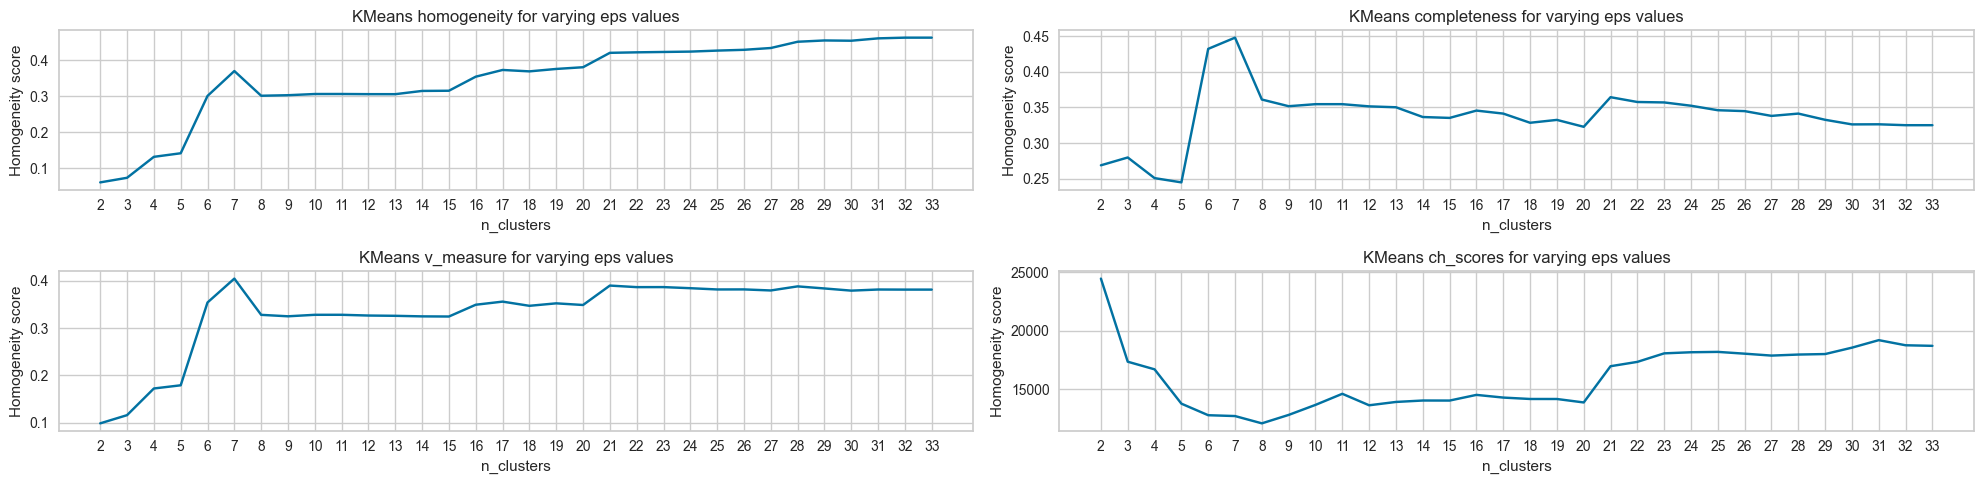

In [57]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 5))

ax[0, 0].plot(n_clusters, homogeneity_scores)
ax[0, 0].set_title('KMeans homogeneity for varying eps values')
ax[0, 0].set_xlabel('n_clusters')
ax[0, 0].set_ylabel('Homogeneity score')
ax[0, 0].set_xticks(n_clusters)
ax[0, 0].grid(visible=True)

ax[0, 1].plot(n_clusters, completeness_scores)
ax[0, 1].set_title('KMeans completeness for varying eps values')
ax[0, 1].set_xlabel('n_clusters')
ax[0, 1].set_ylabel('Completeness score')
ax[0, 1].set_xticks(n_clusters)
ax[0, 1].grid(visible=True)

ax[1, 0].plot(n_clusters, v_measure_scores)
ax[1, 0].set_title('KMeans v_measure for varying eps values')
ax[1, 0].set_xlabel('n_clusters')
ax[1, 0].set_ylabel('V_measure score')
ax[1, 0].set_xticks(n_clusters)
ax[1, 0].grid(visible=True)

ax[1, 1].plot(n_clusters, ch_scores)
ax[1, 1].set_title('KMeans ch_scores for varying eps values')
ax[1, 1].set_xlabel('n_clusters')
ax[1, 1].set_ylabel('Ch_scores score')
ax[1, 1].set_xticks(n_clusters)
ax[1, 1].grid(visible=True)

plt.tight_layout()
plt.show()

By following homogeneity, completeness, and v_measure, clustering tends to perform better with a higher number of clusters (except for completeness, which slightly falls after k=7 clusters). 

# Let's test also DBScan
In DBScan, the eps_values are the radius around the mean points created. 

In [58]:
eps_values = [0.1, 0.3, 0.5, 0.7, 1.0]

In [59]:
homogeneity_scores = []
completeness_scores = []
v_measure_scores = []
ch_scores = []

for eps in eps_values:
    # Register start time
    t_start = time.time()
    dbscan = DBSCAN(eps=eps, n_jobs=-1).fit(X)
    y_pred = dbscan.labels_
    homogeneity_scores.append(homogeneity_score(y, y_pred))
    completeness_scores.append(completeness_score(y, y_pred))
    v_measure_scores.append(v_measure_score(y, y_pred))
    ch_scores.append(calinski_harabasz_score(X, y_pred))
    # Register end time
    t_stop = time.time()
    # Print elapsed time
    print(f"Elapsed time: {t_stop - t_start:.5f} seconds (k: {eps})")

Elapsed time: 53.72845 seconds (k: 0.1)
Elapsed time: 71.60856 seconds (k: 0.3)
Elapsed time: 103.42766 seconds (k: 0.5)
Elapsed time: 59.01302 seconds (k: 0.7)
Elapsed time: 62.92873 seconds (k: 1.0)


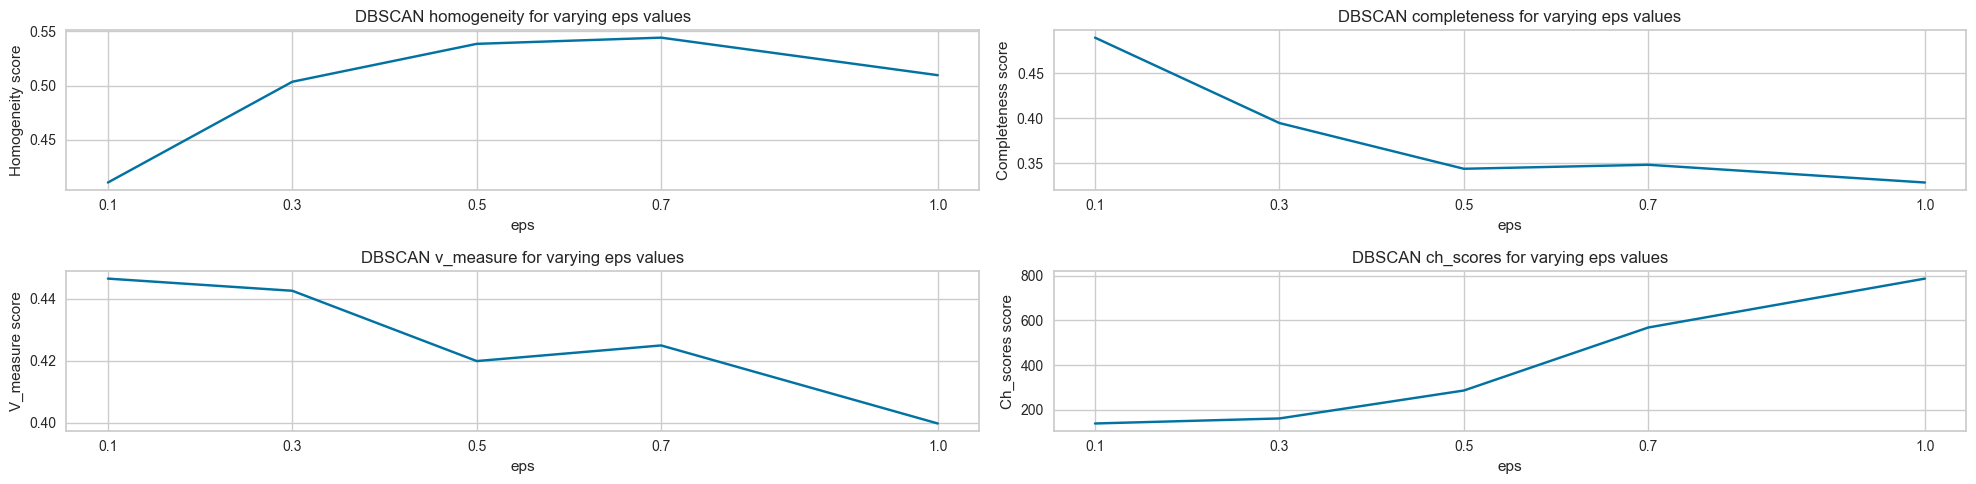

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 5))

ax[0, 0].plot(eps_values, homogeneity_scores)
ax[0, 0].set_xticks(eps_values)
ax[0, 0].set_title('DBSCAN homogeneity for varying eps values')
ax[0, 0].set_xlabel('eps')
ax[0, 0].set_ylabel('Homogeneity score')
ax[0, 0].set_xticks(eps_values)
ax[0, 0].grid(visible=True)

ax[0, 1].plot(eps_values, completeness_scores)
ax[0, 1].set_xticks(eps_values)
ax[0, 1].set_title('DBSCAN completeness for varying eps values')
ax[0, 1].set_xlabel('eps')
ax[0, 1].set_ylabel('Completeness score')
ax[0, 1].set_xticks(eps_values)
ax[0, 1].grid(visible=True)

ax[1, 0].plot(eps_values, v_measure_scores)
ax[1, 0].set_xticks(eps_values)
ax[1, 0].set_title('DBSCAN v_measure for varying eps values')
ax[1, 0].set_xlabel('eps')
ax[1, 0].set_ylabel('V_measure score')
ax[1, 0].set_xticks(eps_values)
ax[1, 0].grid(visible=True)

ax[1, 1].plot(eps_values, ch_scores)
ax[1, 1].set_xticks(eps_values)
ax[1, 1].set_title('DBSCAN ch_scores for varying eps values')
ax[1, 1].set_xlabel('eps')
ax[1, 1].set_ylabel('Ch_scores score')
ax[1, 1].set_xticks(eps_values)
ax[1, 1].grid(visible=True)

plt.tight_layout()
plt.show()

We can see an upward trend in both homogeneity score and DBScan when increasing the eps score. On the other hand v_measure and completeness worsen with higher eps values. 

# Let's test hierarchical clustering

Hierarchical clustering on the entire dataset is extremely slow, because of that we we took a smaller sample of the dataset to work with, with a size of 10000 points. 

In [66]:
X_small, _, y_small, _ = train_test_split(X, y, train_size=10000, random_state=42)

In [67]:
from collections import Counter
Counter(y_small)

Counter({3: 1305,
         5: 1292,
         6: 885,
         1: 1261,
         2: 1306,
         4: 1295,
         0: 1310,
         7: 1346})

In [68]:
X_small.shape

(10000, 42)

In [69]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [70]:
clustering = AgglomerativeClustering(n_clusters=8)
clustering.fit(X_small)
linkage_matrix = linkage(clustering.children_, method='single')

In [71]:
labels = clustering.fit_predict(X_small)

In [72]:
Counter(labels)

Counter({1: 2109, 0: 2880, 3: 2793, 6: 1732, 4: 164, 7: 291, 2: 22, 5: 9})

In [73]:
print("Completeness score: ", completeness_score(y_small, labels))
print("v_measure_score: ", v_measure_score(y_small, labels))
print("Homogeneity score: ", homogeneity_score(y_small, labels))

Completeness score:  0.28742295699392867
v_measure_score:  0.2447527911377867
Homogeneity score:  0.21311431863211572


Does not work well, we see that all three score have values < 0.30.
Hierarchical clustering doesn't work because we already know the amount of clusters we need = 8. 

# Conclusion
We noticed that unsupervised learning for the dataset we selected doesn't work as well as supervised. There can be a few reasons for this:
- Since the data doesn't have a clear distinction from one label to another, assigning the labels within supervised allows the model to learn the correct label while unsupervised doesn't have this point of reference to refer to.   